## TRAIL dataset
- HF: https://huggingface.co/datasets/PatronusAI/TRAIL
- Paper: https://arxiv.org/pdf/2505.08638

- GAIA: Benchmark for General AI Assistants featuring real-world questions requiring reasoning, tool use, multimodality
--> Based on paper: https://arxiv.org/pdf/2311.12983, it seems to only contain single-agent traces
- SWE-bench: software engineering benchmark dataset; real-world GitHub issues + code repos + patches. If I understood challenge giver correctly, these are not the tasks the company is looking at.

**Conclusion:** Concentrate on GAIA-split first, even if it only contains single-agent traces

In [1]:
from datasets import load_dataset
import json
import sys
import os
from typing import List
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
notebook_dir = Path().resolve()
# Go up one level
sys.path.append(str(notebook_dir.parents[0]))
from utils import call_evaluate_steps, extract_output_values, extract_status_codes
from prompting.prompts import *

In [2]:
dataset_name = "PatronusAI/TRAIL"
ds = load_dataset(dataset_name, split="gaia")

In [3]:
ds

Dataset({
    features: ['trace', 'labels'],
    num_rows: 117
})

In [4]:
trace = json.loads(ds["trace"][0])
print(json.dumps(trace, indent=2))

{
  "trace_id": "041b7f9c8c76c2ca1a8e67c6769267c3",
  "spans": [
    {
      "timestamp": "2025-03-19T16:37:55.005053Z",
      "trace_id": "041b7f9c8c76c2ca1a8e67c6769267c3",
      "span_id": "ef641bfc63faffaf",
      "parent_span_id": null,
      "trace_state": "",
      "span_name": "main",
      "span_kind": "Internal",
      "service_name": "gaia-annotation-samples/app:GAIA-Samples",
      "resource_attributes": {
        "pat.account.id": "60d9c474-b732-4a52-b6af-1266f94d60bc",
        "service.name": "gaia-annotation-samples/app:GAIA-Samples",
        "telemetry.sdk.language": "python",
        "telemetry.sdk.name": "opentelemetry",
        "telemetry.sdk.version": "1.30.0"
      },
      "scope_name": "patronus.sdk",
      "scope_version": "",
      "span_attributes": {
        "pat.app": "GAIA-Samples",
        "pat.project.id": "a69d64fc-5115-468e-95ed-0950bd37f06a",
        "pat.project.name": "gaia-annotation-samples"
      },
      "duration": "PT1M24.635189S",
      "statu

In [5]:
label = json.loads(ds["labels"][0])
print(json.dumps(label, indent=2))

{
  "trace_id": "041b7f9c8c76c2ca1a8e67c6769267c3",
  "errors": [
    {
      "category": "Tool-related",
      "location": "1832b9469b9b862d",
      "evidence": "After a search for the number of Nature research articles published in 2020 (excluding book reviews, columns, etc.), a reliable source indicates that Nature published 484 research articles that year.",
      "description": "The system hallucinated the output of the search_agent tool, claiming that a search was performed and returned the specific value '484' for the number of Nature research articles published in 2020, despite the preceding trace showing only the initiation of the search task and no observation of the result.",
      "impact": "HIGH"
    },
    {
      "category": "Formatting Errors",
      "location": "227551d8e97e8f38",
      "evidence": "Error: Code execution failed at line 'final_answer = incorrect_papers' due to: InterpreterError: Cannot assign to name 'final_answer': doing this would erase the existing t

### Understanding the data

Each trace looks like:
```
{
    "trace_id": "...",
    "spans": [... nested spans ...]
}
```
* **trace_id**: unique ID for the entire session
* **spans**: each is a step (or nested sub-step) of computation
* **parent_span_id**: defines the tree structure
* **child_spans**: nested children (recursively defined)
* ...

```
main (span_id=ef64...)
├── step_1 (span_id=84ac3f...)
│   ├── substep_1
│   └── substep_2
└── step_2
```


In [6]:
trace.keys()

dict_keys(['trace_id', 'spans'])

### Prompting the model

In [7]:
call_evaluate_steps(["What is 2+3?", "What is 4+5?"], system_prompt=PROMPT_TEMPLATE_OVERALL_SCORE_SYSTEM, user_prompt=PROMPT_TEMPLATE_OVERALL_SCORE_USER)

[Warning] evaluate_step_openai failed: name 'shared_cache' is not defined


['', '']

### Setup ground truth
- In labels per trace there is an overall score that takes into account execution and planning
- We define GT value as mean value of overall scores across all traces

In [8]:
errors = 0
def get_gt_label(example):
    global errors
    labels = example["labels"]

    if isinstance(labels, str):
        try:
            labels = json.loads(labels)
        except json.JSONDecodeError:
            errors += 1
            return None

    scores = labels.get("scores", [])
    overall_values = [ele["overall"] for ele in scores if "overall" in ele]
    print(overall_values)
    example["overall_score"] = np.mean(overall_values) if overall_values else None
    return example

ds = ds.map(get_gt_label)

In [9]:
ds

Dataset({
    features: ['trace', 'labels', 'overall_score'],
    num_rows: 116
})

In [10]:
errors

0

We have 116 samples (1 removed because label had wrong format). As this is a pretty small number, use CV.

### Analyze labels

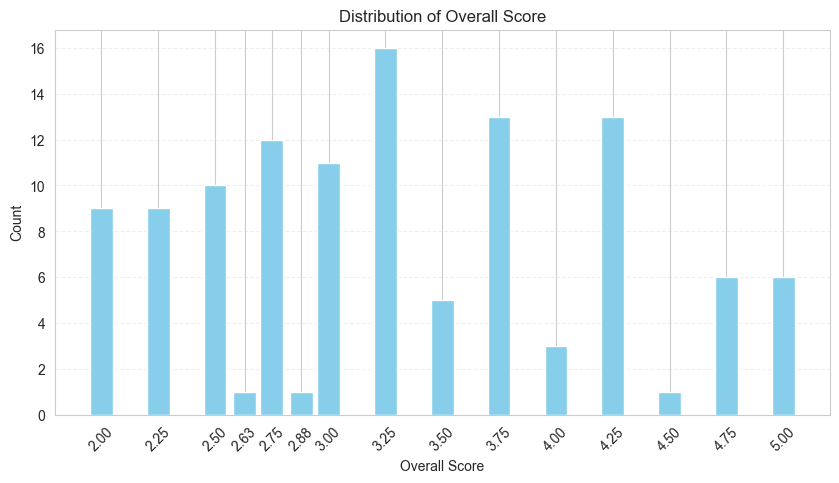

In [11]:
value_counts = Counter(ds["overall_score"])
values = sorted(value_counts.keys())           # x-axis positions
counts = [value_counts[v] for v in values]    # heights of bars

plt.figure(figsize=(10,5))
plt.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
plt.bar(values, counts, width=0.1, color="skyblue", align='center', zorder=3)
plt.xlabel("Overall Score")
plt.ylabel("Count")
plt.title("Distribution of Overall Score")

# Show the actual value under each bar
plt.xticks(values, [f"{v:.2f}" for v in values], rotation=45)
plt.show()

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

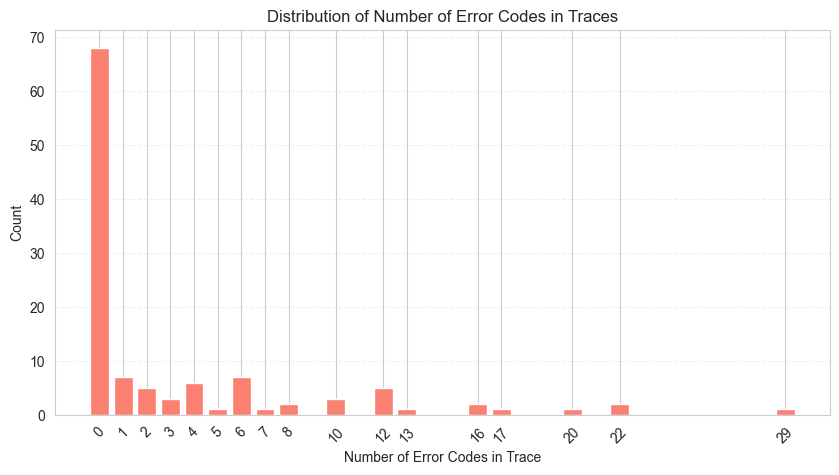

In [16]:
# Plot distribution of number of error codes in traces
def count_error_codes(example):
    status_codes = extract_status_codes(example["trace"])
    status_codes = [i["status_code"] for i in status_codes]
    num_errors = sum(1 for code in status_codes if code == "Error")
    example["num_error_codes"] = num_errors
    return example
ds = ds.map(count_error_codes)

plt.figure(figsize=(10,5))
value_counts = Counter(ds["num_error_codes"])
values = sorted(value_counts.keys())           # x-axis positions
counts = [value_counts[v] for v in values]    # heights of bars
plt.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
plt.bar(values, counts,  color="salmon", align='center', zorder=3)
plt.xlabel("Number of Error Codes in Trace")
plt.ylabel("Count")
plt.title("Distribution of Number of Error Codes in Traces")
# Show the actual value under each bar
plt.xticks(values, [str(v) for v in values], rotation=45)
plt.show()


In [17]:
# Compute correlation between number of error codes and overall score
from scipy.stats import pearsonr
num_errors = np.array(ds["num_error_codes"])
overall_scores = np.array(ds["overall_score"])
correlation, p_value = pearsonr(num_errors, overall_scores)
print(f"Pearson correlation between number of error codes and overall score: {correlation:.4f} (p-value: {p_value:.4e})")

Pearson correlation between number of error codes and overall score: -0.1019 (p-value: 2.7617e-01)


In [18]:
# Consider portion of errors in status codes vs overall score
def compute_error_portion(example):
    status_codes = extract_status_codes(example["trace"])
    status_codes = [i["status_code"] for i in status_codes]
    total_codes = len(status_codes)
    if total_codes == 0:
        example["error_portion"] = 0.0
    else:
        num_errors = sum(1 for code in status_codes if code == "Error")
        example["error_portion"] = num_errors / total_codes
    return example
ds = ds.map(compute_error_portion)

# Compute correlation between error portion and overall score
error_portions = np.array(ds["error_portion"])
correlation, p_value = pearsonr(error_portions, overall_scores)
print(f"Pearson correlation between error portion and overall score: {correlation:.4f} (p-value: {p_value:.4e})")

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Pearson correlation between error portion and overall score: -0.0741 (p-value: 4.2939e-01)


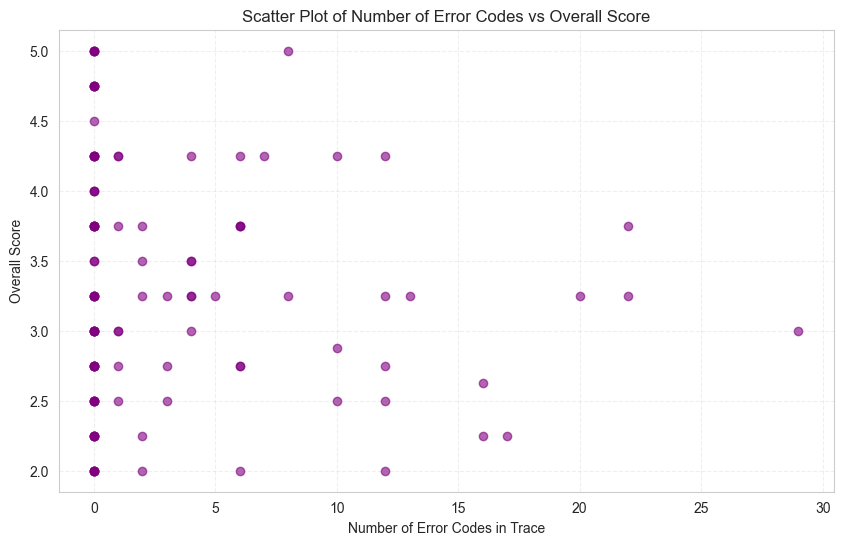

In [19]:
# Plot scatter of number of error codes vs overall score
plt.figure(figsize=(10,6))
plt.scatter(ds["num_error_codes"], ds["overall_score"], color="purple", alpha=0.6)
plt.xlabel("Number of Error Codes in Trace")
plt.ylabel("Overall Score")
plt.title("Scatter Plot of Number of Error Codes vs Overall Score")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

### CV setup

In [12]:
def cross_validate_5fold_regression(dataset, predict_fn):
    """
    dataset: HuggingFace Dataset
    predict_fn: function that takes a list of examples and returns numeric predictions (list)
    Returns: list of 5 fold scores
    """
    n = len(dataset)
    indices = np.arange(n)
    kf = KFold(n_splits=5, shuffle=True, random_state=2)

    fold_scores = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(indices), 1):
        test_data = dataset.select(list(test_idx))  # HuggingFace Dataset's native batch selection
        y_true = np.array(test_data["overall_score"], dtype=float)
        y_pred = np.array(predict_fn(test_data), dtype=float)


        score = mean_squared_error(y_true, y_pred)

        print(f"Fold {fold_idx}: MSE = {score:.4f}")
        fold_scores.append(score)

    return fold_scores

### Baseline
Predict 1 if there is at least one error code, 5 else

In [13]:
def baseline_predict(df):
    preds = []
    for trace in df["trace"]:
        status_codes = extract_status_codes(trace)
        status_codes = [i["status_code"] for i in status_codes]
        if "Error" not in status_codes:
            preds.append(5)
        else:
            preds.append(1)
    return preds

scores_baseline = cross_validate_5fold_regression(ds, baseline_predict)
print(f"Mean score Baseline: {np.mean(scores_baseline):.4f}")

Fold 1: MSE = 3.9494
Fold 2: MSE = 4.7813
Fold 3: MSE = 3.9728
Fold 4: MSE = 4.7636
Fold 5: MSE = 4.1005
Mean score Baseline: 4.3135


### Prompt 1: Just insert full concatenated output.value and prompt a score if trace is correct or not
1) Extract all output.value
2) Concat them with new line
3) Prompt model to provide an overall score for that
4) Clip to range [1, 5]

In [ ]:
PREDICTION_FILE = "llm_predictions_overall_prompting.jsonl"


def prompt_concat_output(df):
    """
    Extracts all output.value fields from each trace, concatenates them,
    prompts the model to score each concatenated output, clips the score to [1, 5],
    and saves all predictions to a JSONL file.
    """
    # Step 1: extract concatenated outputs
    concatenated_outputs = []
    for trace in df["trace"]:
        trace_obj = json.loads(trace)
        outputs = extract_output_values(trace_obj)
        concatenated_outputs.append("\n".join(outputs))

    # Step 2: call the LLM evaluator
    raw_scores = call_evaluate_steps(
        concatenated_outputs,
        system_prompt=PROMPT_TEMPLATE_OVERALL_SCORE_SYSTEM,
        user_prompt=PROMPT_TEMPLATE_OVERALL_SCORE_USER,
    )

    # Prepare output lists
    scores = []
    records_to_write = []

    # Step 3: parse scores + prepare JSONL rows
    for idx, (raw, concat) in enumerate(zip(raw_scores, concatenated_outputs)):
        # extract first token as float
        try:
            score = float(raw.strip().split()[0])
        except:
            score = 1.0  # fallback for malformed outputs

        # clip to [1, 5]
        score = max(1.0, min(5.0, score))
        scores.append(score)

        # build record
        record = {
            "index": idx,
            #"concatenated_output": concat,
            "raw_llm_output": raw,
            "score": score,
        }
        records_to_write.append(record)

    # Step 4: append predictions to JSONL file
    with open(PREDICTION_FILE, "a", encoding="utf-8") as f:
        for rec in records_to_write:
            f.write(json.dumps(rec) + "\n")

    print(scores)
    return scores
scores_prompt_concat_output = cross_validate_5fold_regression(ds, prompt_concat_output)
print(f"Mean score Prompt Concat Output: {np.mean(scores_prompt_concat_output):.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

Loaded 232 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 24/24 [00:03<00:00,  7.09it/s]


[5.0, 4.5, 3.5, 4.5, 5.0, 5.0, 3.5, 5.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5.0, 3.5, 3.5, 5.0, 3.5, 5.0, 2.5, 5.0, 4.5, 5.0]
Fold 1: MSE = 2.3802


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 256 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


[4.5, 4.5, 3.5, 2.5, 4.5, 4.5, 5.0, 5.0, 5.0, 2.4, 4.5, 5.0, 4.5, 2.0, 4.5, 3.5, 3.5, 4.5, 4.5, 4.5, 3.5, 3.5, 3.5]
Fold 2: MSE = 1.4769


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 279 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:01<00:00, 12.49it/s]


[2.5, 5.0, 3.5, 5.0, 4.5, 4.5, 5.0, 4.5, 5.0, 4.0, 4.5, 5.0, 4.0, 4.5, 5.0, 4.5, 5.0, 5.0, 4.5, 5.0, 5.0, 3.0, 4.5]
Fold 3: MSE = 1.9402


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 302 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:03<00:00,  6.82it/s]


[5.0, 5.0, 4.5, 4.5, 3.5, 4.5, 4.5, 4.5, 5.0, 5.0, 5.0, 4.5, 5.0, 5.0, 5.0, 4.5, 4.5, 3.5, 5.0, 3.5, 5.0, 2.5, 4.0]
Fold 4: MSE = 2.7853


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 325 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:10<00:00,  2.16it/s]

[3.5, 4.5, 4.5, 3.5, 3.5, 4.5, 3.5, 4.5, 5.0, 3.5, 3.5, 4.5, 5.0, 5.0, 2.5, 4.5, 3.5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Fold 5: MSE = 2.0897
Mean score Prompt Concat Output: 2.1345


### Prompt 2: Prompt separately for the subsections, then take the average of these subsections

In [ ]:
PREDICTIONS_PATH = "llm_predictions_subcategory_prompting.jsonl" 


def _parse_llm_json(raw: str) -> dict:
    """
    Parse JSON returned by the LLM.
    Handles cases like:
    - plain JSON
    - JSON wrapped in ```json ... ``` or ``` ... ```
    """
    s = raw.strip()
    if s.startswith("```"):
        s = s.split("```", 2)
        if len(s) >= 3:
            s = s[1]  # content after first ```
        else:
            s = s[-1]
        s = s.lstrip("json").lstrip()
    return json.loads(s)


def prompt_concat_output(df) -> List[float]:
    """
    Extracts all output.value fields from each trace, concatenates them,
    prompts the model to score each concatenated output, and returns
    the LLM's final_score (1–5) for each example.

    Additionally, saves all full JSON predictions (with sub-scores)
    into a JSONL file on disk (PREDICTIONS_PATH).
    """

    concatenated_outputs = []
    traces_raw = df["trace"]  

    for trace in traces_raw:
        trace_obj = json.loads(trace)
        outputs = extract_output_values(trace_obj)
        concatenated_outputs.append("\n".join(outputs))

    
    raw_scores = call_evaluate_steps(
        concatenated_outputs,
        system_prompt=PROMPT_TEMPLATE_SUBCATEGORY_PREDICTION_SYSTEM, user_prompt=PROMPT_TEMPLATE_SUBCATEGORY_PREDICTION_USER)

    
    final_scores = []
    records_to_write = []

    for idx, (raw, concat_out) in enumerate(zip(raw_scores, concatenated_outputs)):
        parsed = _parse_llm_json(raw)

        
        def clip_score(key: str) -> float:
            val = float(parsed.get(key, 1.0))
            return max(1.0, min(5.0, val))

        reliability = clip_score("reliability")
        security = clip_score("security")
        instruction_adherence = clip_score("instruction_adherence")
        plan_optimality = clip_score("plan_optimality")

        if "final_score" in parsed:
            final_score = float(parsed["final_score"])
        else:
            final_score = (
                reliability + security + instruction_adherence + plan_optimality
            ) / 4.0

        final_score = max(1.0, min(5.0, final_score))
        final_scores.append(final_score)

        record = {
            "index": idx,
            "concatenated_output": concat_out,
            "reliability": reliability,
            "security": security,
            "instruction_adherence": instruction_adherence,
            "plan_optimality": plan_optimality,
            "final_score": final_score,
        }
        records_to_write.append(record)

    with open(PREDICTIONS_PATH, "a", encoding="utf-8") as f:
        for rec in records_to_write:
            f.write(json.dumps(rec) + "\n")

    print(final_scores)
    return final_scores

scores_subecategory_prompt_concat_output = cross_validate_5fold_regression(ds, prompt_concat_output)
print(f"Mean score Prompt Concat Output: {np.mean(scores_subecategory_prompt_concat_output):.4f}")

100%|██████████| 24/24 [00:06<00:00,  3.78it/s]


[4.25, 4.25, 3.5, 4.25, 5.0, 5.0, 2.75, 5.0, 4.25, 5.0, 4.25, 4.25, 4.25, 4.25, 5.0, 3.75, 3.75, 4.25, 3.0, 4.25, 3.0, 4.25, 4.25, 5.0]
Fold 1: MSE = 1.8438


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 24 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:08<00:00,  2.82it/s]


[4.25, 3.75, 4.25, 3.0, 5.0, 4.25, 4.0, 5.0, 5.0, 2.75, 4.25, 5.0, 4.25, 3.75, 3.75, 4.25, 3.5, 4.0, 5.0, 4.25, 4.25, 4.25, 3.0]
Fold 2: MSE = 1.2446


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 47 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:04<00:00,  5.37it/s]


[2.75, 4.25, 3.0, 5.0, 3.75, 5.0, 5.0, 4.25, 4.25, 3.75, 4.25, 5.0, 4.25, 4.25, 4.25, 3.75, 5.0, 5.0, 5.0, 4.25, 5.0, 3.25, 4.25]
Fold 3: MSE = 1.1413


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 70 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:05<00:00,  4.09it/s]


[4.25, 4.25, 4.25, 3.75, 3.75, 4.25, 4.25, 5.0, 4.25, 5.0, 4.25, 4.25, 5.0, 5.0, 4.25, 4.25, 4.25, 4.25, 4.25, 3.75, 5.0, 3.0, 4.5]
Fold 4: MSE = 2.0245


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 93 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:07<00:00,  2.97it/s]


[3.0, 4.25, 4.25, 4.25, 4.25, 5.0, 4.25, 4.25, 5.0, 3.5, 2.75, 3.75, 4.25, 5.0, 3.0, 4.25, 3.75, 5.0, 5.0, 4.25, 5.0, 5.0, 5.0]
Fold 5: MSE = 2.1223


NameError: name 'scores_prompt_concat_output' is not defined

### PROMPT 3: One shot-prompting

In [14]:
PREDICTION_FILE = "llm_predictions_one_shot_prompting.jsonl"


def prompt_concat_output(df):
    """
    Extracts all output.value fields from each trace, concatenates them,
    prompts the model to score each concatenated output, clips the score to [1, 5],
    and saves all predictions to a JSONL file.
    """
    # Step 1: extract concatenated outputs
    concatenated_outputs = []
    for trace in df["trace"]:
        trace_obj = json.loads(trace)
        outputs = extract_output_values(trace_obj)
        concatenated_outputs.append("\n".join(outputs))

    # Step 2: call the LLM evaluator
    raw_scores = call_evaluate_steps(
        concatenated_outputs,
        system_prompt=PROMPT_TEMPLATE_ONE_SHOT_SYSTEM,
        user_prompt=PROMPT_TEMPLATE_ONE_SHOT_USER,
    )

    # Prepare output lists
    scores = []
    records_to_write = []

    # Step 3: parse scores + prepare JSONL rows
    for idx, (raw, concat) in enumerate(zip(raw_scores, concatenated_outputs)):
        # extract first token as float
        try:
            score = float(raw.strip().split()[0])
        except:
            score = 1.0  # fallback for malformed outputs

        # clip to [1, 5]
        score = max(1.0, min(5.0, score))
        scores.append(score)

        # build record
        record = {
            "index": idx,
            #"concatenated_output": concat,
            "raw_llm_output": raw,
            "score": score,
        }
        records_to_write.append(record)

    # Step 4: append predictions to JSONL file
    with open(PREDICTION_FILE, "a", encoding="utf-8") as f:
        for rec in records_to_write:
            f.write(json.dumps(rec) + "\n")

    print(scores)
    return scores
scores_one_shot_prompt_concat_output = cross_validate_5fold_regression(ds, prompt_concat_output)
print(f"Mean score Prompt Concat Output: {np.mean(scores_one_shot_prompt_concat_output):.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

Loaded 116 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 24/24 [00:03<00:00,  6.17it/s]


[5.0, 3.0, 3.0, 3.0, 5.0, 5.0, 2.0, 5.0, 2.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 3.0, 3.0, 4.0, 3.0, 5.0, 2.0, 3.0, 2.0, 3.0]
Fold 1: MSE = 1.3860


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 140 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


[4.0, 3.0, 3.0, 1.0, 3.0, 2.0, 5.0, 3.0, 4.0, 2.4, 4.0, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0]
Fold 2: MSE = 0.8091


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 163 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:03<00:00,  6.98it/s]


[1.0, 3.0, 3.0, 5.0, 3.0, 4.5, 3.0, 3.0, 3.0, 5.0, 3.0, 4.5, 4.0, 3.0, 4.0, 3.0, 3.0, 5.0, 4.0, 5.0, 5.0, 2.0, 3.0]
Fold 3: MSE = 1.3641


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 186 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:05<00:00,  4.14it/s]


[4.0, 5.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 5.0, 3.0, 3.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 5.0, 1.0, 4.5]
Fold 4: MSE = 1.5788


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 209 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:06<00:00,  3.62it/s]

[3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 2.0, 3.0, 3.0, 2.0, 3.0, 1.0, 3.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Fold 5: MSE = 1.9266
Mean score Prompt Concat Output: 1.4129


### PROMPT 4: Three-Shots prompting 

In [13]:
PREDICTION_FILE = "llm_predictions_three_shot_prompting.jsonl"


def prompt_concat_output(df):
    """
    Extracts all output.value fields from each trace, concatenates them,
    prompts the model to score each concatenated output, clips the score to [1, 5],
    and saves all predictions to a JSONL file.
    """
    # Step 1: extract concatenated outputs
    concatenated_outputs = []
    for trace in df["trace"]:
        trace_obj = json.loads(trace)
        outputs = extract_output_values(trace_obj)
        concatenated_outputs.append("\n".join(outputs))

    # Step 2: call the LLM evaluator
    raw_scores = call_evaluate_steps(
        concatenated_outputs,
        system_prompt=PROMPT_TEMPLATE_THREE_SHOT_SYSTEM,
        user_prompt=PROMPT_TEMPLATE_THREE_SHOT_USER,
    )

    # Prepare output lists
    scores = []
    records_to_write = []

    # Step 3: parse scores + prepare JSONL rows
    for idx, (raw, concat) in enumerate(zip(raw_scores, concatenated_outputs)):
        # extract first token as float
        try:
            score = float(raw.strip().split()[0])
        except:
            score = 1.0  # fallback for malformed outputs

        # clip to [1, 5]
        score = max(1.0, min(5.0, score))
        scores.append(score)

        # build record
        record = {
            "index": idx,
            #"concatenated_output": concat,
            "raw_llm_output": raw,
            "score": score,
        }
        records_to_write.append(record)

    # Step 4: append predictions to JSONL file
    with open(PREDICTION_FILE, "a", encoding="utf-8") as f:
        for rec in records_to_write:
            f.write(json.dumps(rec) + "\n")

    print(scores)
    return scores
scores_three_shot_prompt_concat_output = cross_validate_5fold_regression(ds, prompt_concat_output)
print(f"Mean score Prompt Concat Output: {np.mean(scores_three_shot_prompt_concat_output):.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

Loaded 348 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 24/24 [00:04<00:00,  5.04it/s]


[4.0, 3.5, 3.0, 3.0, 4.5, 4.5, 2.5, 4.0, 3.0, 4.5, 3.5, 3.0, 3.5, 4.0, 5.0, 2.5, 3.0, 3.0, 3.5, 4.0, 2.0, 3.0, 2.5, 4.0]
Fold 1: MSE = 1.0681


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 372 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:06<00:00,  3.41it/s]


[3.0, 3.0, 3.5, 1.0, 3.0, 3.0, 4.5, 3.0, 3.5, 2.4, 3.5, 4.0, 3.0, 3.0, 3.0, 3.5, 3.0, 3.5, 3.0, 2.5, 2.5, 3.0, 3.0]
Fold 2: MSE = 0.4882


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 395 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


[2.0, 3.0, 3.5, 3.5, 3.0, 3.5, 3.5, 3.5, 3.5, 3.0, 3.0, 3.5, 4.0, 3.0, 3.0, 3.0, 3.5, 4.5, 3.5, 4.0, 5.0, 2.5, 3.5]
Fold 3: MSE = 0.7989


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 418 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


[3.5, 2.5, 3.5, 3.0, 3.5, 3.5, 3.5, 3.5, 3.5, 4.0, 3.0, 3.5, 3.0, 4.5, 3.0, 3.0, 3.5, 3.5, 4.0, 3.5, 5.0, 1.0, 4.5]
Fold 4: MSE = 1.1984


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 441 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:09<00:00,  2.52it/s]

[3.5, 3.0, 3.5, 2.5, 3.5, 3.5, 3.0, 3.5, 4.0, 3.0, 3.0, 3.0, 2.5, 3.0, 2.5, 3.5, 2.5, 4.5, 5.0, 4.0, 5.0, 5.0, 3.0]
Fold 5: MSE = 1.1332
Mean score Prompt Concat Output: 0.9374


### Prompt 5: Subcategory + 3-shot prompting

In [ ]:
PREDICTIONS_PATH = "llm_predictions_subcategory_three-shots_prompting.jsonl" 


def _parse_llm_json(raw: str) -> dict:
    """
    Parse JSON returned by the LLM.
    Handles cases like:
    - plain JSON
    - JSON wrapped in ```json ... ``` or ``` ... ```
    """
    s = raw.strip()
    if s.startswith("```"):
        s = s.split("```", 2)
        if len(s) >= 3:
            s = s[1]  # content after first ```
        else:
            s = s[-1]
        s = s.lstrip("json").lstrip()
    return json.loads(s)


def prompt_concat_output(df) -> List[float]:
    """
    Extracts all output.value fields from each trace, concatenates them,
    prompts the model to score each concatenated output, and returns
    the LLM's final_score (1–5) for each example.

    Additionally, saves all full JSON predictions (with sub-scores)
    into a JSONL file on disk (PREDICTIONS_PATH).
    """

    concatenated_outputs = []
    traces_raw = df["trace"]  

    for trace in traces_raw:
        trace_obj = json.loads(trace)
        outputs = extract_output_values(trace_obj)
        concatenated_outputs.append("\n".join(outputs))

    
    raw_scores = call_evaluate_steps(
        concatenated_outputs,
        system_prompt=PROMPT_TEMPLATE_SUBCATEGORY_THREE_SHOTS_PREDICTION_SYSTEM, user_prompt=PROMPT_TEMPLATE_SUBCATEGORY_THREE_SHOTS_PREDICTION_USER)

    
    final_scores = []
    records_to_write = []

    for idx, (raw, concat_out) in enumerate(zip(raw_scores, concatenated_outputs)):
        parsed = _parse_llm_json(raw)

        
        def clip_score(key: str) -> float:
            val = float(parsed.get(key, 1.0))
            return max(1.0, min(5.0, val))

        reliability = clip_score("reliability")
        security = clip_score("security")
        instruction_adherence = clip_score("instruction_adherence")
        plan_optimality = clip_score("plan_optimality")

        if "final_score" in parsed:
            final_score = float(parsed["final_score"])
        else:
            final_score = (
                reliability + security + instruction_adherence + plan_optimality
            ) / 4.0

        final_score = max(1.0, min(5.0, final_score))
        final_scores.append(final_score)

        record = {
            "index": idx,
            #"concatenated_output": concat_out,
            "reliability": reliability,
            "security": security,
            "instruction_adherence": instruction_adherence,
            "plan_optimality": plan_optimality,
            "final_score": final_score,
        }
        records_to_write.append(record)

    with open(PREDICTIONS_PATH, "a", encoding="utf-8") as f:
        for rec in records_to_write:
            f.write(json.dumps(rec) + "\n")

    print(final_scores)
    return final_scores

scores_subcategory_three_shots_prompt_concat_output = cross_validate_5fold_regression(ds, prompt_concat_output)
print(f"Mean score Prompt Concat Output: {np.mean(scores_subcategory_three_shots_prompt_concat_output):.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

Loaded 464 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 24/24 [00:05<00:00,  4.43it/s]


[5.0, 4.25, 3.0, 3.75, 5.0, 5.0, 2.75, 5.0, 3.0, 4.0, 3.5, 3.0, 4.0, 4.0, 5.0, 3.0, 3.0, 4.5, 2.75, 5.0, 2.75, 3.0, 4.25, 4.25]
Fold 1: MSE = 1.4038


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 488 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:07<00:00,  3.02it/s]


[3.0, 2.5, 3.75, 2.75, 3.0, 2.75, 3.75, 4.25, 5.0, 2.75, 3.5, 5.0, 3.5, 3.0, 3.75, 3.75, 2.75, 4.25, 4.25, 4.0, 4.25, 4.25, 2.75]
Fold 2: MSE = 0.6576


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 511 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:04<00:00,  4.96it/s]


[2.75, 4.0, 2.75, 4.25, 3.0, 4.25, 3.75, 3.75, 4.0, 4.0, 4.25, 4.25, 4.0, 3.75, 3.75, 2.75, 4.25, 5.0, 4.5, 5.0, 5.0, 2.75, 4.0]
Fold 3: MSE = 0.8832


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 534 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:06<00:00,  3.67it/s]


[4.25, 4.25, 5.0, 3.75, 3.0, 4.0, 3.75, 4.25, 4.25, 5.0, 5.0, 3.75, 5.0, 5.0, 4.25, 2.75, 3.75, 4.0, 5.0, 3.75, 5.0, 2.75, 4.25]
Fold 4: MSE = 1.9565


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 557 items from cache/gpt-4o-mini.jsonl in 0.0 seconds


100%|██████████| 23/23 [00:07<00:00,  3.21it/s]

[2.75, 2.75, 3.0, 3.75, 3.75, 4.0, 4.25, 4.25, 5.0, 2.75, 2.5, 3.75, 5.0, 4.25, 2.75, 4.25, 3.0, 5.0, 5.0, 4.5, 5.0, 5.0, 5.0]
Fold 5: MSE = 1.5652
Mean score Prompt Concat Output: 1.2933


### Visualize

## Overall comparisons

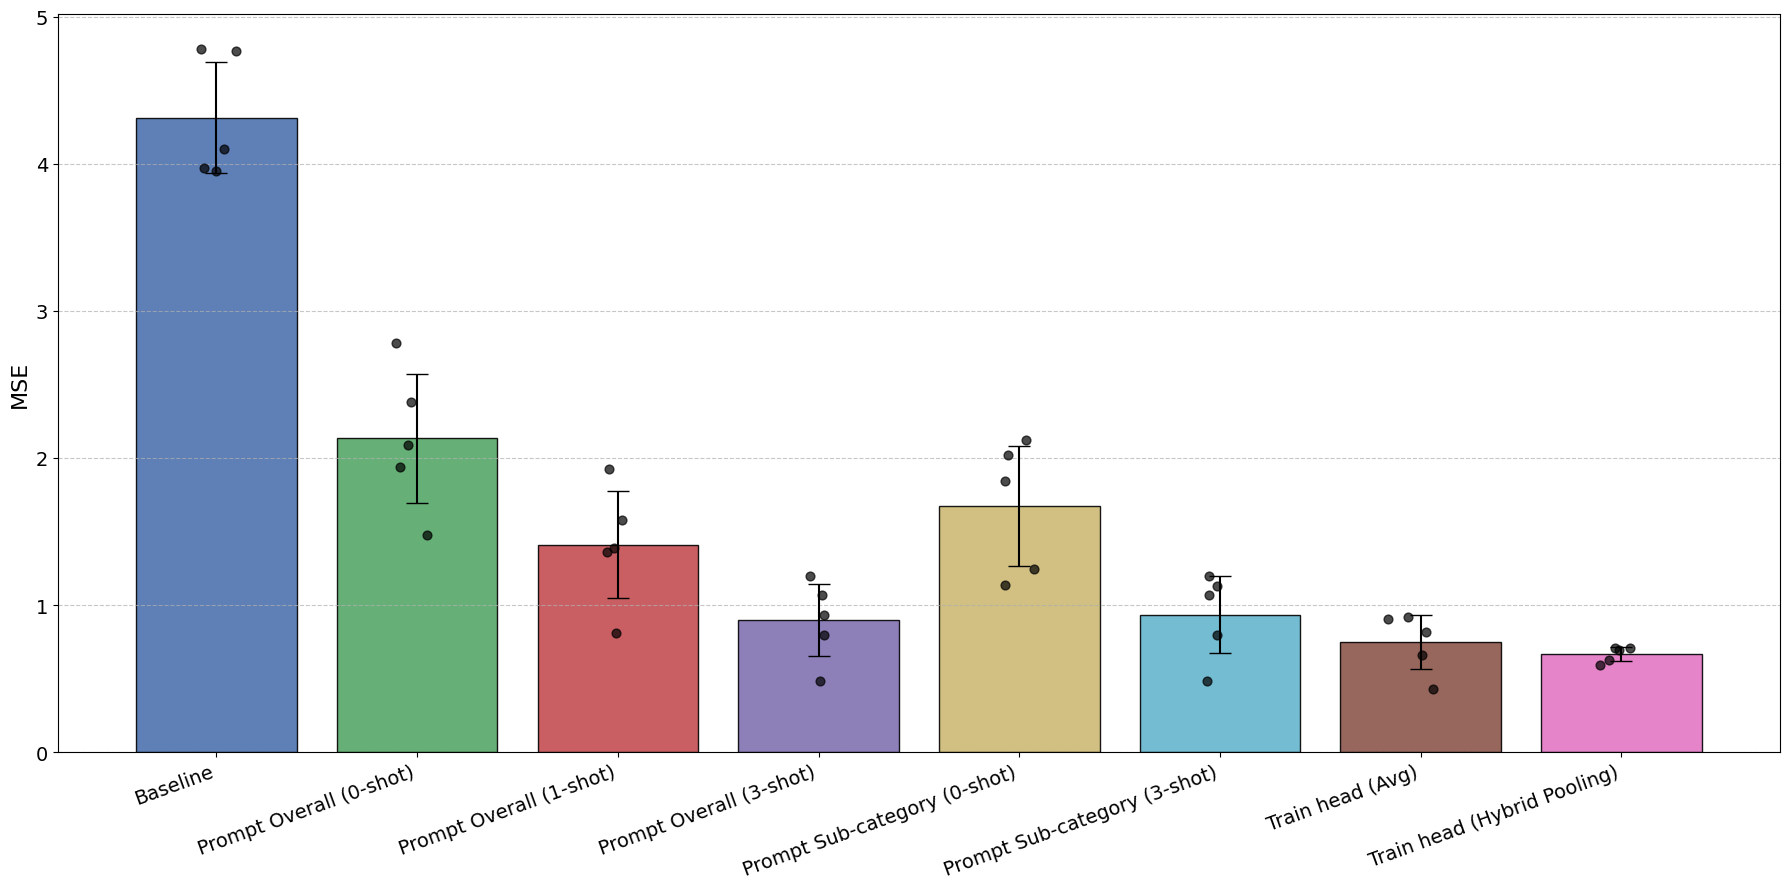

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mse_comparison(
    scores_baseline,
    scores_prompt_overall_0shot,
    scores_prompt_overall_1shot,
    scores_prompt_overall_3shot,
    scores_prompt_subcat_0shot,
    scores_prompt_subcat_3shot,
    scores_train_head_avg,
    scores_train_head_hybrid,
):
    # Labels in desired order
    labels = [
        "Baseline",
        "Prompt Overall (0-shot)",
        "Prompt Overall (1-shot)",
        "Prompt Overall (3-shot)",
        "Prompt Sub-category (0-shot)",
        "Prompt Sub-category (3-shot)",
        "Train head (Avg)",
        "Train head (Hybrid Pooling)",
    ]

    # Collect score lists in the same order as labels
    score_lists = [
        scores_baseline,
        scores_prompt_overall_0shot,
        scores_prompt_overall_1shot,
        scores_prompt_overall_3shot,
        scores_prompt_subcat_0shot,
        scores_prompt_subcat_3shot,
        scores_train_head_avg,
        scores_train_head_hybrid,
    ]

    # Compute means and std deviation
    means = [np.mean(s) for s in score_lists]
    stds  = [np.std(s) for s in score_lists]

    # 8 colors for 8 bars
    colors = [
        "#4C72B0",  # Baseline
        "#55A868",  # Prompt overall 0-shot
        "#C44E52",  # Prompt overall 1-shot
        "#8172B2",  # Prompt overall 3-shot
        "#CCB974",  # Sub-cat 0-shot
        "#64B5CD",  # Sub-cat 3-shot
        "#8C564B",  # Train head (Avg)
        "#E377C2",  # Train head (Hybrid)
    ]

    plt.figure(figsize=(18, 9))
    bars = plt.bar(
        labels,
        means,
        yerr=stds,
        capsize=8,
        color=colors,
        edgecolor="black",
        alpha=0.9,
    )

    # Jittered scatter points for each fold score
    for i, scores in enumerate(score_lists):
        x = np.random.normal(i, 0.05, size=len(scores))  # jitter around bar center
        plt.scatter(x, scores, color="black", zorder=5, alpha=0.7, s=40)

    plt.ylabel("MSE", fontsize=16)
    plt.xticks(rotation=20, ha="right")  # helps avoid overlap

    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.tight_layout()
    plt.show()
plot_mse_comparison(
    scores_baseline,
    scores_prompt_concat_output,              # Prompt Overall (0-shot)
    scores_one_shot_prompt_concat_output,     # Prompt Overall (1-shot)
    scores_three_shot_prompt_concat_output,   # Prompt Overall (3-shot)
    scores_subecategory_prompt_concat_output,  # Prompt Sub-category (0-shot)
    scores_subcategory_three_shot_prompt_concat_output,  # Prompt Sub-category (3-shot)
    scores_train_head_avg,                    # Train head (Avg)
    scores_train_head_hybrid_pooling,                 # Train head (Hybrid Pooling)
)